In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Task/'

# SETUP

In [ ]:
!git clone https://github.com/cloneofsimo/lora.git && sed -i 's/functools.cache/functools.lru_cache(maxsize=None)/g' /content/drive/MyDrive/Task/lora/lora_diffusion/xformers_utils.py && pip install /content/drive/MyDrive/Task/lora
!pip install accelerate bitsandbytes

Cloning into 'lora'...
remote: Enumerating objects: 934, done.
remote: Counting objects: 100% (407/407), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 934 (delta 346), reused 301 (delta 301), pack-reused 527
Receiving objects: 100% (934/934), 182.96 MiB | 15.84 MiB/s, done.
Resolving deltas: 100% (560/560), done.
Updating files: 100% (60/60), done.
Processing ./lora
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.1/989.1 kB 14.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 100.5 MB/s

# TRAINING

In [ ]:
import os
import shutil

PRETRAINED_MODEL="runwayml/stable-diffusion-v1-5"
PROMPT="KallashV" #due to uniquely identified
TRAINING_IMAGES_FOLDER="/content/drive/MyDrive/Task/KalashValleyImages"
OUTPUT_DIR="/content/drive/MyDrive/Task/model_output"

if not os.path.exists(OUTPUT_DIR):
    %mkdir -p "$OUTPUT_DIR"

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

images = []

for i in range(1, 21):
    img_path = os.path.join(TRAINING_IMAGES_FOLDER, f'{i}.jpeg')
    img = cv2.imread(img_path)
    if img is not None:
        images.append(img)
    else:
        print(f"Image {i}.jpeg not found")

fig, axes = plt.subplots(4, 5, figsize=(12, 10))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!python lora/training_scripts/train_lora_dreambooth.py --pretrained_model_name_or_path=runwayml/stable-diffusion-v1-5 --instance_data_dir=$TRAINING_IMAGES_FOLDER --output_dir=$OUTPUT_DIR --instance_prompt=$PROMPT --resolution=512 --use_8bit_adam --mixed_precision=fp16 --train_batch_size=1 --gradient_accumulation_steps=1 --learning_rate=0.0003 --lr_scheduler=constant --lr_warmup_steps=0 --max_train_steps=5000 --train_text_encoder --lora_rank=16 --learning_rate_text=0.0001 --save_steps 500

2023-09-06 07:52:37.899348: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Before training: Unet First Layer lora up tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Before training: Unet First Layer lora down tensor([[-0.0711,  0.0322,  0.0624,  ...,  0.1345, -0.0573,  0.0872],
        [ 0.0703,  0.0958,  0.1074,  ..., -0.0007, -0.0020, -0.0217],
        [-0.0746, -0.0796, -0.0514,  ...,  0.0035,  0.0454,  0.0887],
        ...,
        [-0.0863,  0.0004,  0.0444,  ..., -0.0628,  0.0832, -0.0039],
        [-0.0372, -0.0679,  0.0048,  ...,  0.0076, -0.0471,  0.0207],
        [-0.0267, -0.0225, -0.1120,  ..., -0.0024,  0.0512, -0.1061]])
Before training: text encoder First Layer lora up tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0.,

# INFERENCE

LOADING MODEL AND MONKEY PATCHING IT

In [ ]:
import torch
from lora_diffusion import monkeypatch_or_replace_lora, tune_lora_scale
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(PRETRAINED_MODEL, torch_dtype=torch.float16).to("cuda")
monkeypatch_or_replace_lora(pipe.unet, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.pt")))
monkeypatch_or_replace_lora(pipe.text_encoder, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.text_encoder.pt")), target_replace_module=["CLIPAttention"])
pipe.safety_checker = None

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

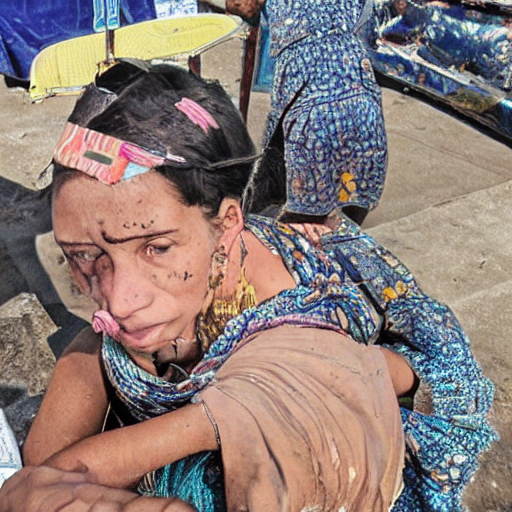

In [ ]:
INFERENCE_PROMPT = 'girl at KallashV'
LORA_SCALE_UNET = 0.1
LORA_SCALE_TEXT_ENCODER = 0.1
GUIDANCE = 1.4
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

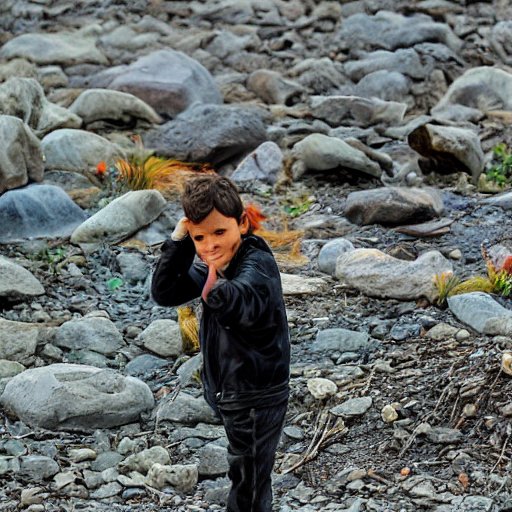

In [ ]:
INFERENCE_PROMPT = 'boy at KallashV'
LORA_SCALE_UNET = 0.1
LORA_SCALE_TEXT_ENCODER = 0.1
GUIDANCE = 1.4
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

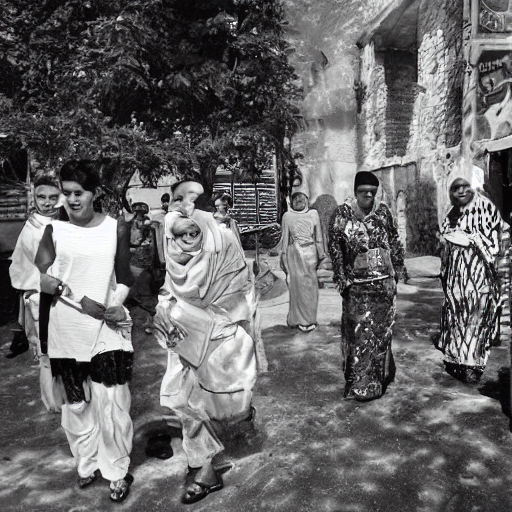

In [ ]:
INFERENCE_PROMPT = 'peoples at KallashV'
LORA_SCALE_UNET = 0.1
LORA_SCALE_TEXT_ENCODER = 0.1
GUIDANCE = 1.4
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)
image = pipe(INFERENCE_PROMPT, num_inference_steps=50, guidance_scale=GUIDANCE).images[0]
image